In [143]:
import sys
import time
from pydriller import RepositoryMining
from pydriller import ModificationType
from collections import defaultdict
import functools
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
REPOSITORY_URL = '/Users/janschill/code/rails/rails'
PROJECT_REPOSITORY_URL = '/Users/janschill/code/janschill/uni-project'
DEVOPS_REPOSITORY_URL = '/Users/janschill/code/janschill/uni-devops'

In [39]:
# Only run when absolutely necessary as it traverses ~80k commits
def print_commit_history(url):
    for commit in RepositoryMining(url).traverse_commits():
        print("commit" + str(commit))
        for m in commit.modifications:
            print(
                "- Author {}".format(commit.author.name),
                " modified {}".format(m.filename),
                " with a change type of {}".format(m.change_type.name),
                " and the complexity is {}".format(m.complexity)
            )
# print_commit_history(PROJECT_REPOSITORY_URL)

In [58]:
def handle_change_type(cc, commit, modification):
    new_path = modification.new_path
    old_path = modification.old_path
    try:
        if modification.change_type == ModificationType.RENAME:
            cc_old = cc.get(old_path, (0, []))
            cc[new_path] =  (cc_old[0] + 1, cc_old[1])
            cc.pop(old_path)
        elif modification.change_type == ModificationType.DELETE:
            cc.pop(old_path, '')
        elif modification.change_type == ModificationType.ADD:
            cc[new_path] = (1, [])
        else: # modification to existing file
            count, cx = cc[old_path]
            comp = modification.complexity
            cc[old_path] = (count + 1, cx + [comp] if comp else cx)
    except Exception as e: 
#                 print("something went wrong with: " + str(modification))
        pass

In [80]:
def rails_components():
    return [
        'activerecord', 'activesupport',
        'actionpack', 'railties',
        'actionview', 'activemodel',
        'activestorage', 'activejob',
        'actionmailbox', 'actioncable',
        'actiontext', 'actionmailer'
    ]

In [81]:
def rails_components_dict():
    cs = {}
    for c in rails_components():
        cs[c] = defaultdict(int)
    return cs

In [82]:
def add_other_components(rails_components, components):
    for c in components:
        others = [cc for cc in components if cc != c]
        for o in others:
            rails_components[c][o] += 1
    return rails_components

In [93]:
rails_components_dictionary = rails_components_dict()

@functools.lru_cache(maxsize=None)
def modifications_complexities(url):
    cc = defaultdict(lambda: (0, []))
    for commit in RepositoryMining(url).traverse_commits():
        changed_components = []
        for modification in commit.modifications:
            comp = ''
            if modification.old_path:
                comp = modification.old_path.rsplit('/')[0]
            else:
                comp = modification.new_path.rsplit('/')[0]
            if comp in rails_components():
                changed_components.append(comp)
            handle_change_type(cc, commit, modification)
        add_other_components(rails_components_dictionary, changed_components)
        changed_components = []

    return cc

## Strongest four couplings per component

In [266]:
# Sort by value
for key, value in rails_components_dictionary.items():
    rails_components_dictionary[key] = {k: v for k, v in sorted(value.items(), key=lambda item: item[1], reverse=True)}
    
def table_coupling():
    format = "{:<14}{:<2}{:<10}"
    for k, v in rails_components_dictionary.items():
        print(k)
        print('-------------------------')
        for kk, vv in v.items():
            print(format.format(kk, ' | ', vv))
        print()
table_coupling()

activerecord
-------------------------
activesupport  | 650434    
actionpack     | 512923    
railties       | 395371    
actionview     | 289649    
activemodel    | 186977    
activejob      | 145045    
actioncable    | 112008    
actionmailer   | 72305     
activestorage  | 1113      
actiontext     | 138       
actionmailbox  | 130       

activesupport
-------------------------
activerecord   | 650434    
actionpack     | 318181    
railties       | 244547    
actionview     | 178098    
activemodel    | 114503    
activejob      | 90583     
actioncable    | 70245     
actionmailer   | 44069     
activestorage  | 480       
actiontext     | 71        
actionmailbox  | 50        

actionpack
-------------------------
activerecord   | 512923    
activesupport  | 318181    
railties       | 202884    
actionview     | 167056    
activemodel    | 89538     
activejob      | 67057     
actioncable    | 51645     
actionmailer   | 42215     
activestorage  | 514       
actiontext    

In [207]:
def couplings(componentA, componentB):
    return rails_components_dictionary[componentA][componentB]/50

def coupling_graphs(component, couplings):
    graph = nx.Graph()
    graph.add_node(component)
    index = 0
    for k, v in couplings.items():
        if index < 5:
            graph.add_node(k)
            graph.add_edge(component, k)
        index += 1
    return graph

def draw_graph_with_weights(G, component, weight_function, figsize=(14,10)):
    node_weights = [weight_function(component, each) for each in G.nodes if each != component]
    node_weights.insert(0, 10000)
    plt.figure(figsize=figsize)
    nx.draw(G, with_labels=True, node_size=node_weights, node_color='lightblue')
    plt.show()

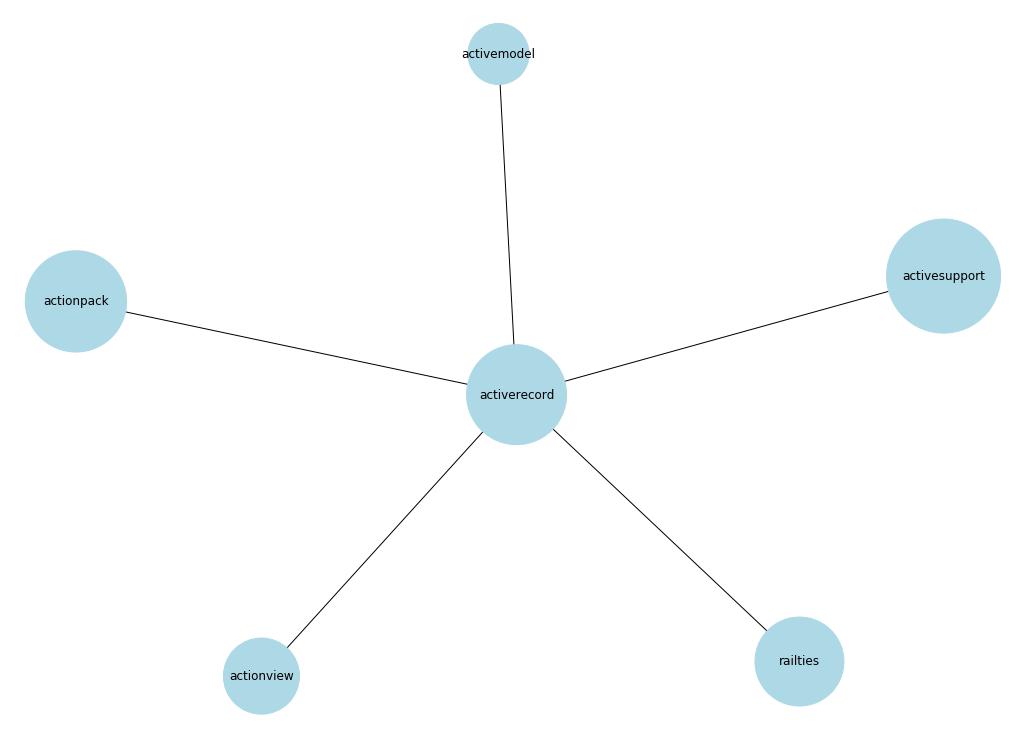

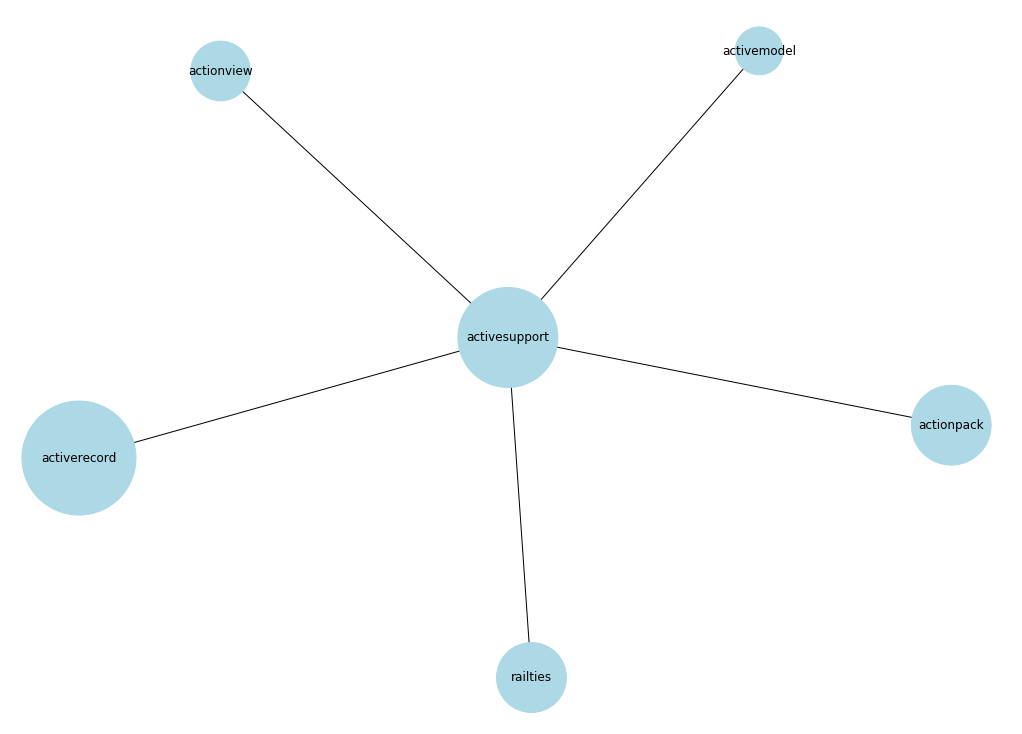

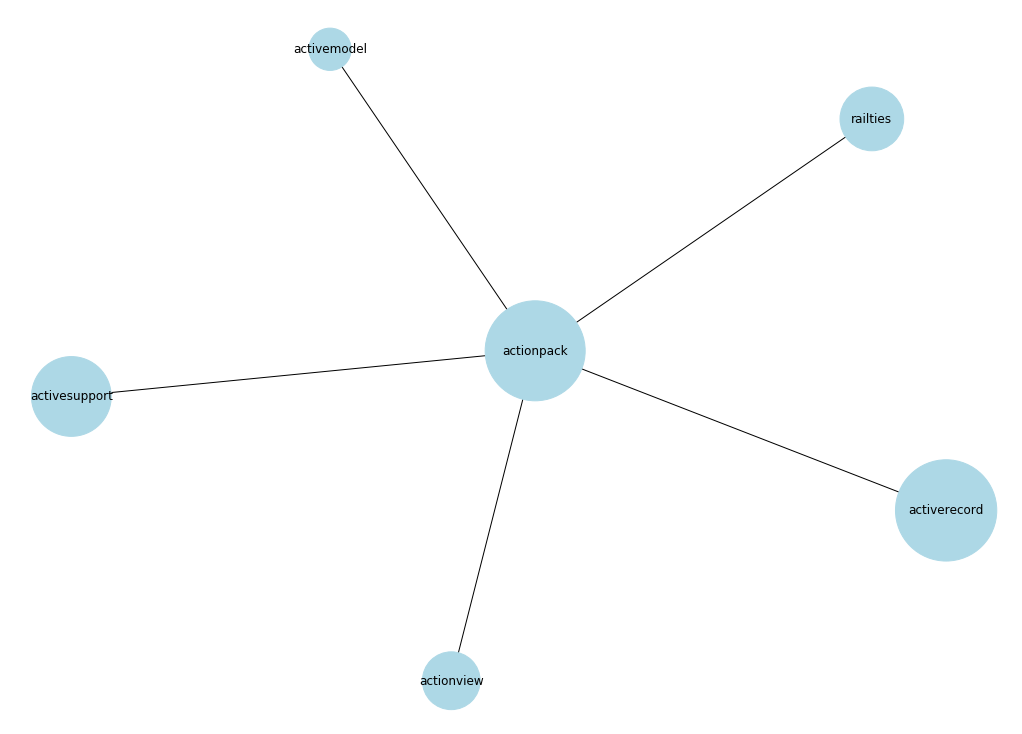

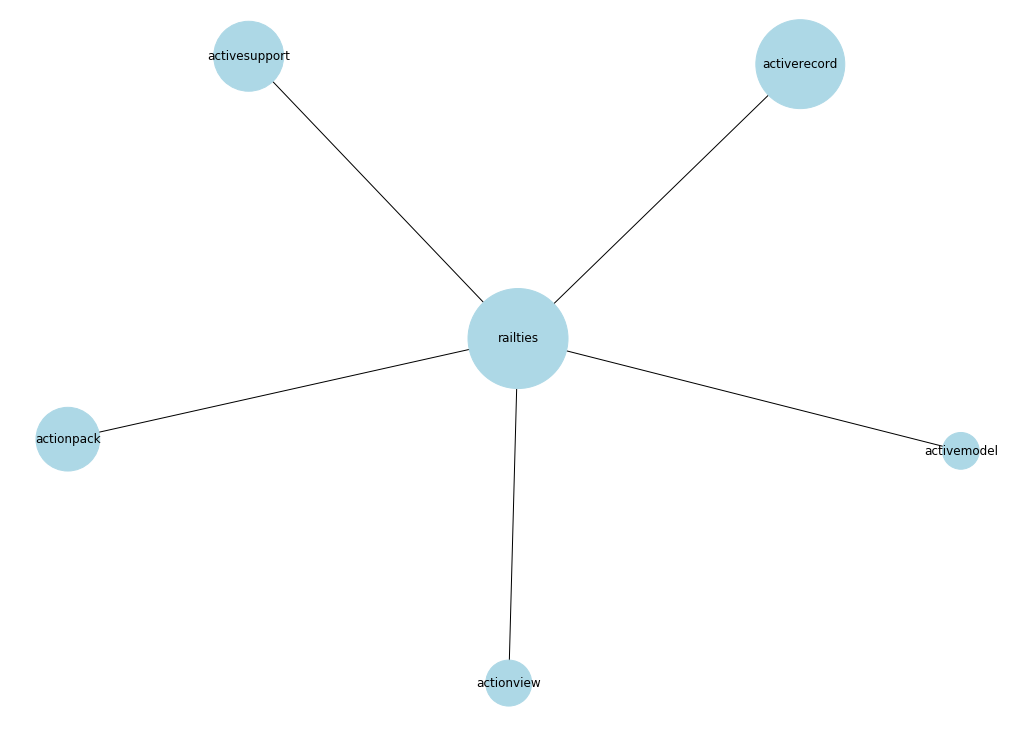

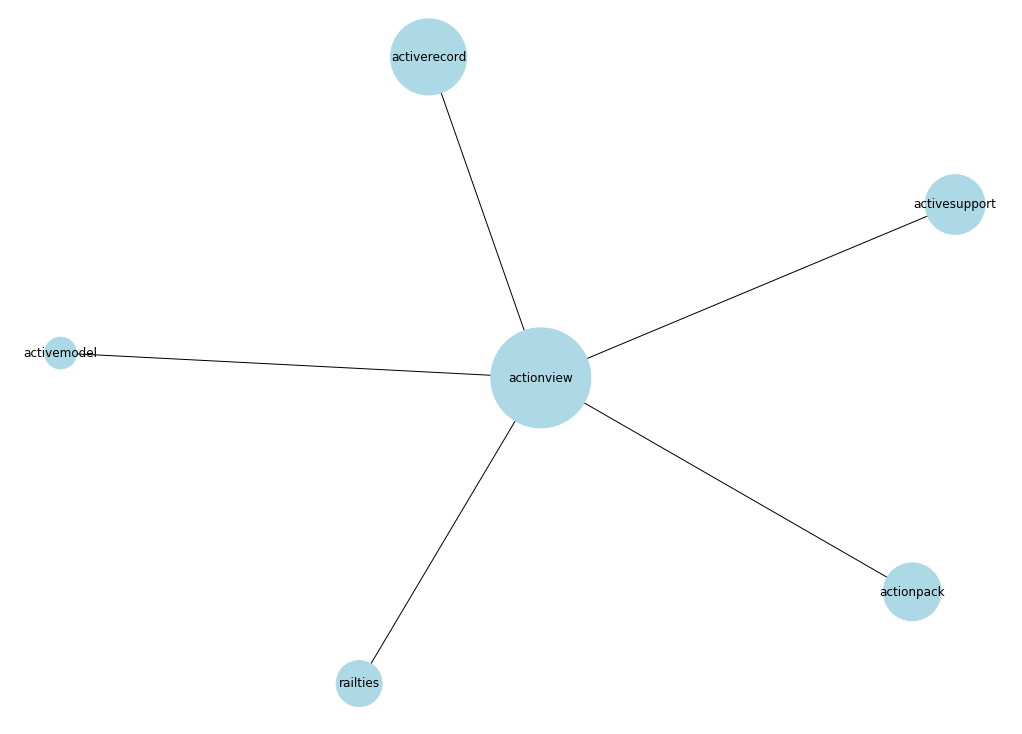

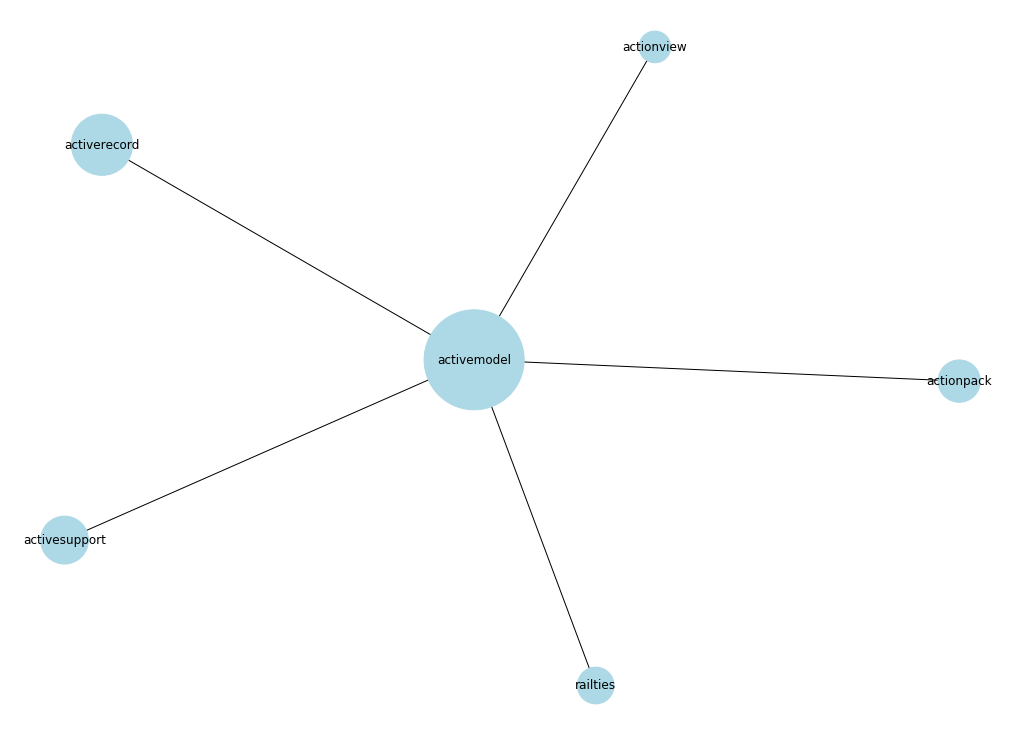

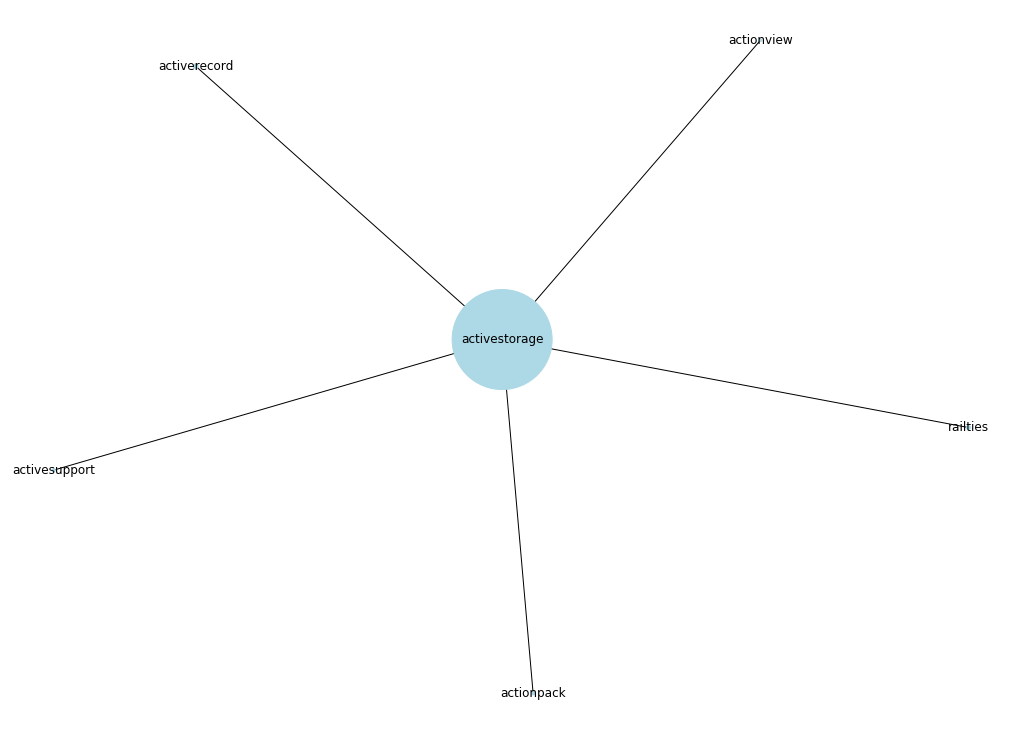

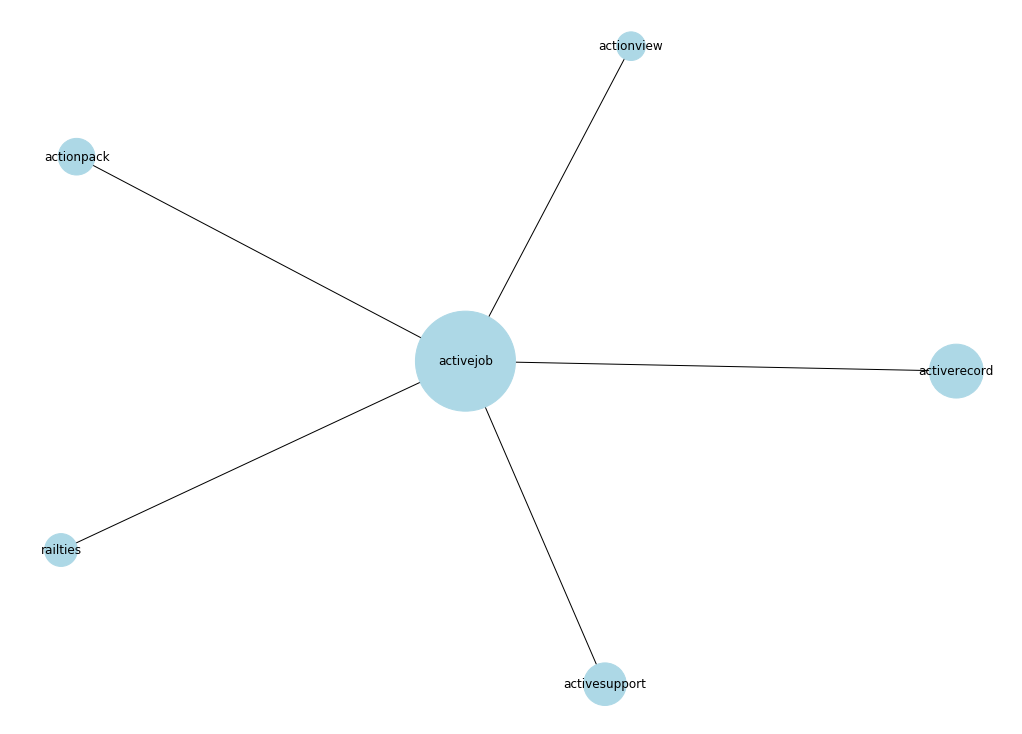

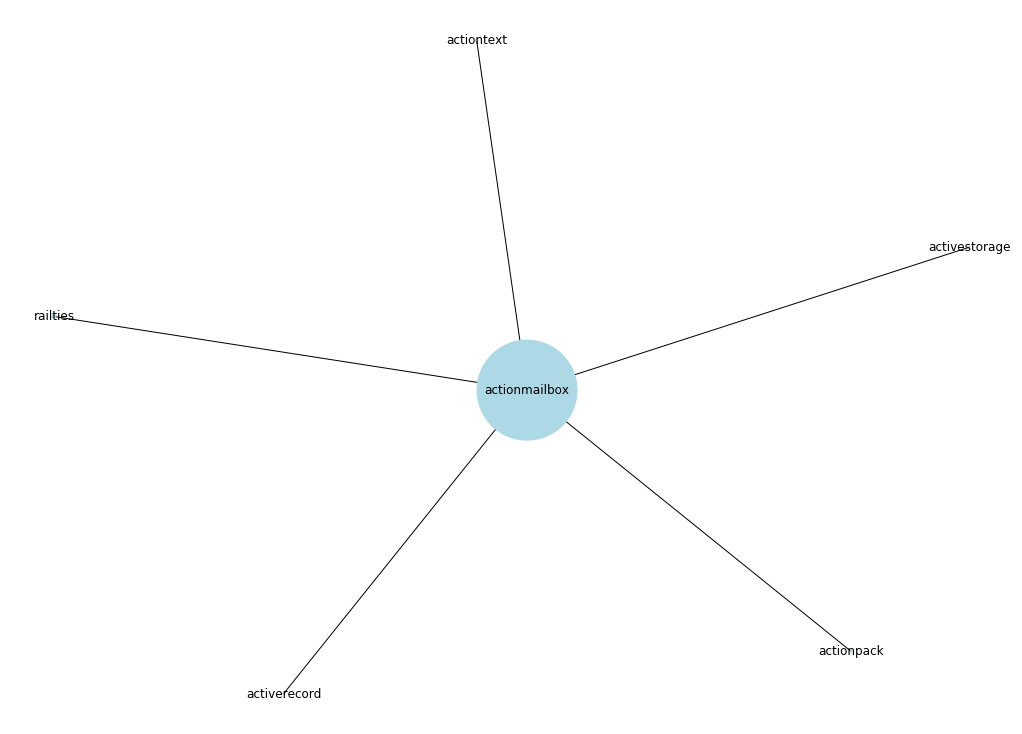

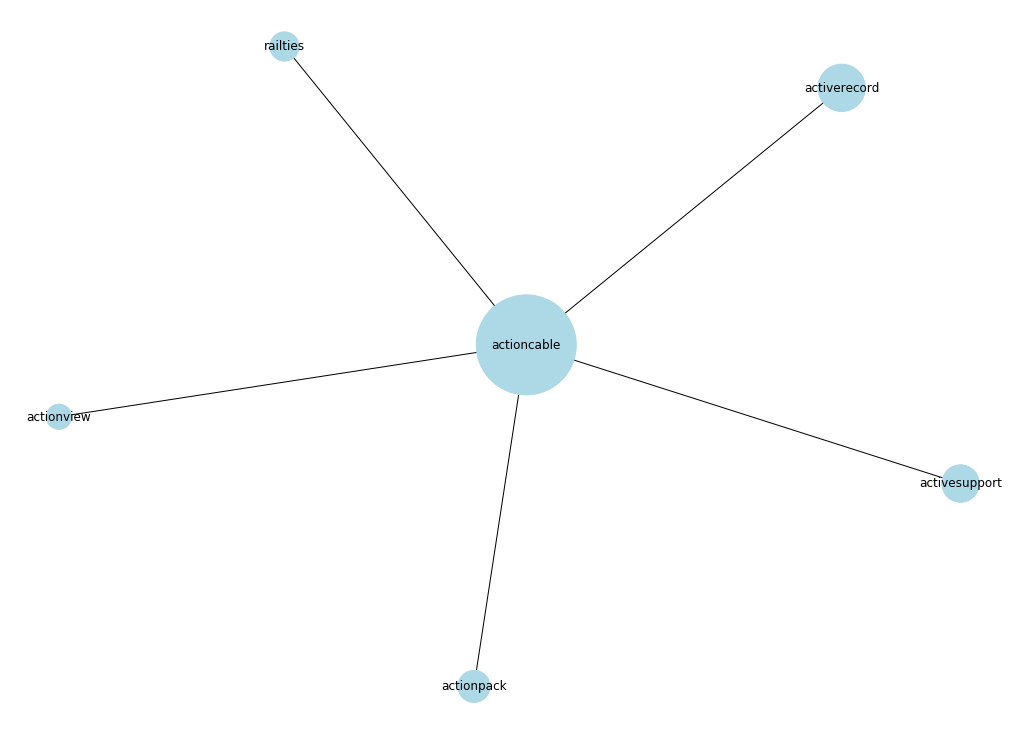

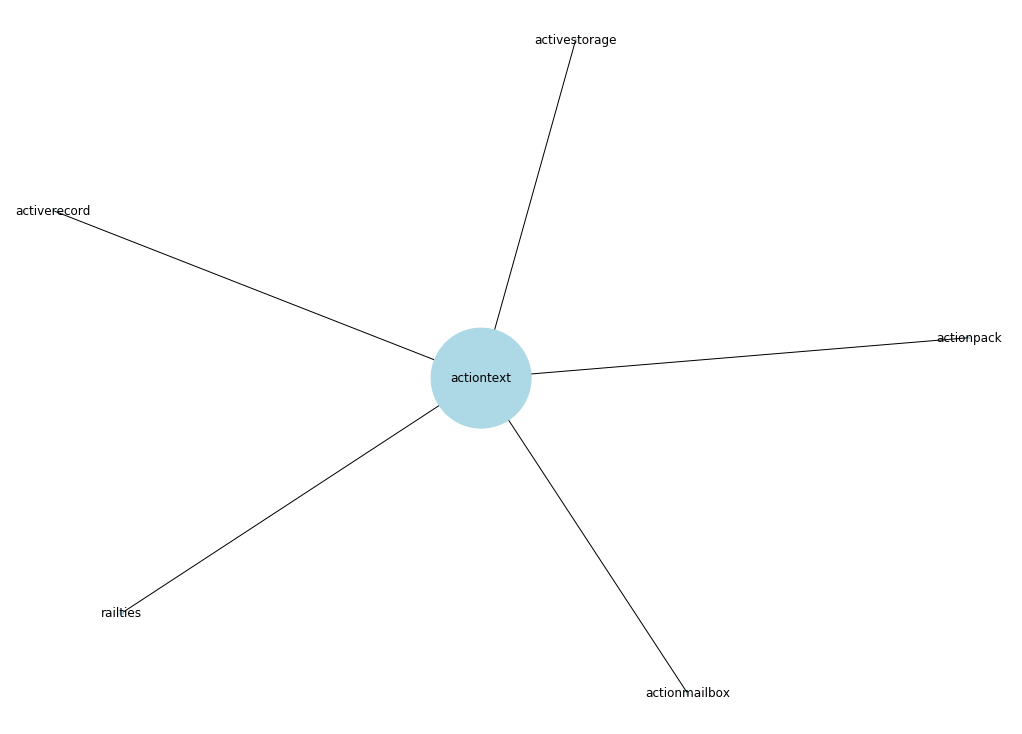

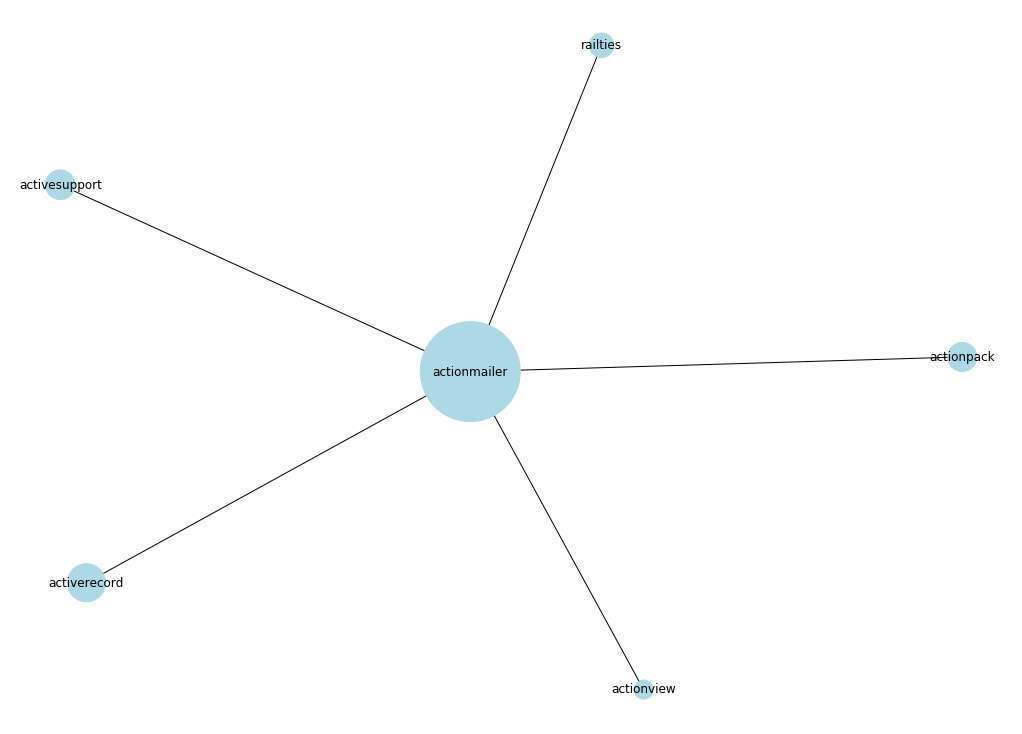

In [208]:
for k, v in rails_components_dictionary.items():
    graph = coupling_graphs(k, v)
    draw_graph_with_weights(graph, k, couplings)

In [138]:
# mdcxs = modifications_complexities(REPOSITORY_URL)

In [139]:
mdcxs

defaultdict(<function __main__.modifications_complexities.<locals>.<lambda>()>,
            {'actionmailer/MIT-LICENSE': (16, []),
             'actionmailer/Rakefile': (103, []),
             'actionmailer/lib/action_mailer.rb': (113,
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
             'actionmailer/lib/action_mailer/base.rb': (547,
              [21,
               21,
               18,
               18,
               20,
               20,
               20,
               21,
               26,
               26,
               27,
               27,
               27,
               27,
               27,
               27,
               34,
               34,
               34,
               34,
               36,
               36,
               37,
               37,
               32,
               37,
               37,
               37,
               37,
               37,
               38,
               39,
               

In [123]:
def get_average_complexity_per_file():
    average_complexity = {}
    for k, v in mdcxs.items():
        average_complexity[k] = sum(v[1]) / len(v[1]) if len(v[1]) > 0 else 0

    return average_complexity

In [124]:
def get_average_complexity_per_component():
    average_complexity = defaultdict(int)
    for k, v in get_average_complexity_per_file().items():
        comp = k.rsplit('/')[0]
        if comp in rails_components():
            average_complexity[comp] = (average_complexity[comp] + v) / 2
    
    return average_complexity

## Average complexity per component

In [141]:
get_average_complexity_per_component()

defaultdict(int,
            {'actionmailer': 0.7983353558919721,
             'actionpack': 1.3987980914407876,
             'activerecord': 13.889115080086412,
             'railties': 0.07679093399052517,
             'activesupport': 8.060649338646105,
             'activemodel': 4.688127252525658,
             'actionview': 5.780472355998456,
             'activejob': 1.0622172972125288,
             'actioncable': 1.376950716647243,
             'activestorage': 1.6255195653017998,
             'actionmailbox': 1.0002444983989265,
             'actiontext': 5.513615926263686e-05})

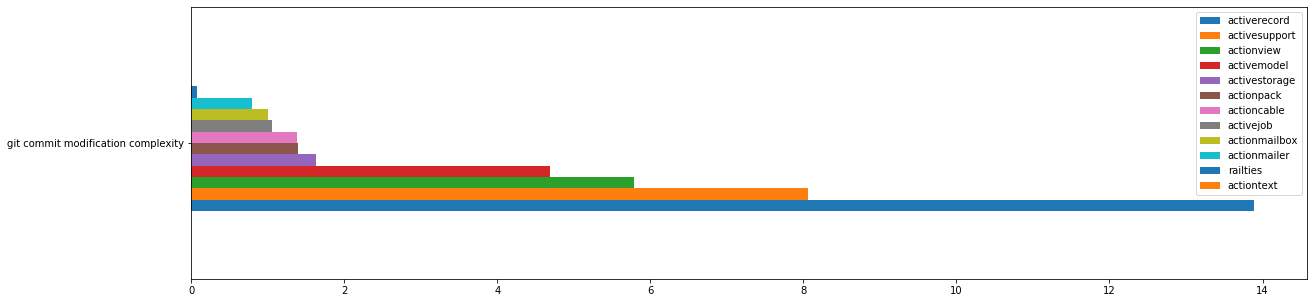

In [211]:
ds = {k: v for k, v in sorted(get_average_complexity_per_component().items(), key=lambda item: item[1], reverse=True)}
df = pd.DataFrame(ds, index=['git commit modification complexity'])
ax = df.plot.barh(figsize=(20,5))

In [126]:
@functools.lru_cache(maxsize=None)
def count_file_modifications_simple(url, tag):
    commit_counts = defaultdict(int)
    for commit in RepositoryMining(url, from_tag=tag).traverse_commits():
        for modification in commit.modifications:
            try:
                commit_counts[modification.new_path] += 1
            except: 
                pass
    return commit_counts

In [127]:
@functools.lru_cache(maxsize=None)
def count_file_modifications(url, tag):
    commit_counts = {}
    for commit in RepositoryMining(url, from_tag=tag).traverse_commits():
        for modification in commit.modifications:
            
            new_path = modification.new_path
            old_path = modification.old_path
            try:
                if modification.change_type == ModificationType.RENAME:
                    commit_counts[new_path]=commit_counts.get(old_path,0)+1
                    commit_counts.pop(old_path)
                elif modification.change_type == ModificationType.DELETE:
                    commit_counts.pop(old_path, '')
                elif modification.change_type == ModificationType.ADD:
                    commit_counts[new_path] = 1
                else: # modification to existing file
                        commit_counts [old_path] += 1
            except Exception as e: 
                # print("something went wrong with: " + str(modification))
                pass
            
    return commit_counts

In [142]:
# Apr 11, 2008 – First tag
# TODO: Not sure if this actually pulls all commits 
# commit_counts_from_v0 = count_file_modifications(REPOSITORY_URL, 'v0.9.1')
# sorted(commit_counts_from_v0.items(), key=lambda x:x[1], reverse=True)
''

''

In [212]:
# Feb 5, 2010
# commit_counts_from_v3 = count_file_modifications_simple(REPOSITORY_URL, 'v3.0.0.beta1')
commit_counts_from_v3 = mdcxs
# sorted(commit_counts_from_v3.items(), key=lambda x:x[1], reverse=True)

[('activerecord/CHANGELOG.md', (1751, [])),
 ('activerecord/lib/active_record/base.rb',
  (1197,
   [178,
    180,
    180,
    181,
    181,
    183,
    184,
    184,
    189,
    191,
    185,
    186,
    188,
    189,
    189,
    191,
    192,
    192,
    192,
    196,
    196,
    196,
    197,
    196,
    196,
    197,
    196,
    196,
    196,
    196,
    196,
    196,
    195,
    196,
    198,
    199,
    199,
    199,
    207,
    207,
    208,
    210,
    209,
    210,
    210,
    210,
    211,
    212,
    212,
    212,
    214,
    215,
    215,
    219,
    218,
    218,
    218,
    218,
    223,
    223,
    223,
    224,
    224,
    224,
    224,
    224,
    224,
    227,
    227,
    227,
    227,
    228,
    228,
    228,
    231,
    232,
    232,
    232,
    232,
    232,
    234,
    237,
    240,
    241,
    241,
    242,
    242,
    243,
    243,
    243,
    244,
    244,
    244,
    246,
    246,
    246,
    245,
    245,
    247,
    249,
   

In [213]:
def filter_by_rb(dictionary):
    filtered_by_rb = dict()
    for (key, value) in dictionary.items():
        if key != None and '.rb' in key:
            filtered_by_rb[key] = value
    return filtered_by_rb

In [214]:
filtered_commit_modifications = filter_by_rb(commit_counts_from_v3)
# sorted(filtered_commit_modifications.items(), key=lambda x:x[1], reverse=True)

In [215]:
from pathlib import Path

def get_first_level_path(path_as_string):
    return Path(path_as_string).parts[0]

def group_by_component(dictionary):
    components = defaultdict(list)
    for key, value in filtered_commit_modifications.items():
        first_level = str(get_first_level_path(key))
        components[first_level].append((key, value))
    return components

In [229]:
components = group_by_component(filtered_commit_modifications)

In [227]:
def sum_modifications_by_module(comps):
    components_modifications_total = dict()
    for k, v in comps.items():
        components_modifications_total[k] = sum(i[1][0] for i in v)
    return components_modifications_total

In [243]:
components_with_total_modifications = sum_modifications_by_module(components)
sorted(components_with_total_modifications.items(), key=lambda x:x[1], reverse=True)

[('activerecord', 36569),
 ('actionpack', 16383),
 ('activesupport', 13871),
 ('railties', 11691),
 ('actionview', 10033),
 ('activemodel', 4038),
 ('lib', 2071),
 ('actionmailer', 1836),
 ('actioncable', 1616),
 ('activejob', 1555),
 ('test', 1288),
 ('activestorage', 1083),
 ('guides', 568),
 ('app', 285),
 ('actionmailbox', 154),
 ('actiontext', 98),
 ('tasks', 71),
 ('version.rb', 45),
 ('tools', 16),
 ('config', 12),
 ('db', 8),
 ('ci', 7)]

In [230]:
# Very hacky way of only getting relevant components
# Every component in Rails starts with 'ac': activerecord, actioncable etc
def filter_relevant_components(components):
    relevants = {}
    for k, v in components.items():
        if k in rails_components():
            relevants[k] = v
    return relevants

In [231]:
relevant_components = filter_relevant_components(components_with_total_modifications)

In [235]:
def modifications_graph(components):
    graph = nx.Graph()
    for k, v in components.items():
        component = k
        if component not in graph.nodes:
            graph.add_node(component)
    return graph

def draw_graph_with_weights(G, weight_function, figsize=(14,10)):
    node_weights = [weight_function(each) for each in G.nodes]
    plt.figure(figsize=figsize)
    nx.draw(G, with_labels=True, node_size=node_weights, node_color='lightblue')
    plt.show()

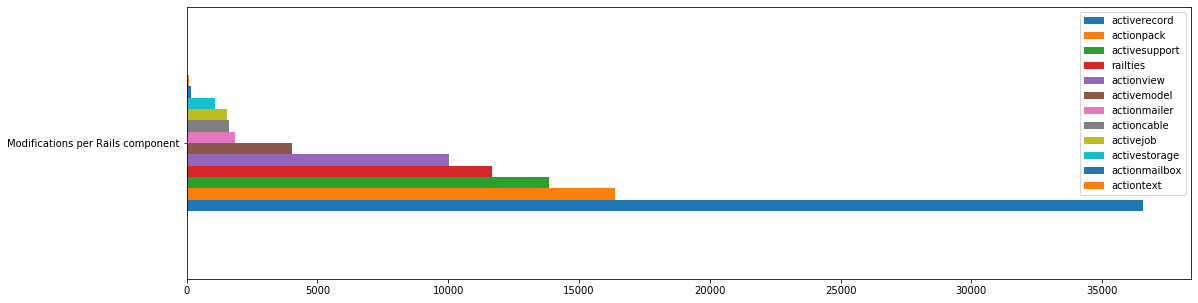

In [239]:
sorted_relevant_components = {k: v for k, v in sorted(relevant_components.items(), key=lambda item: item[1], reverse=True)}
df = pd.DataFrame(sorted_relevant_components, index=['Modifications per Rails component'])
ax = df.plot.barh(figsize=(18,5))
# draw_graph_with_weights(modifications_graph(relevant_components), lambda c: relevant_components[c])